In [1]:
import numpy as np
import scipy as sp
import scipy.signal as sg
import scipy.optimize

### Обрати внимание на mask - так оставляю только часть коэффициентов

In [202]:
def classic(x,y,delim=1):
    return np.sin((x**2 + y**2)/delim**2)

def classic_dfdx(x,y,delim=1):
    return 2*x/delim**2*np.cos((x/delim)**2 + (y/delim)**2)

def classic_dfdy(x,y, delim=1):
    return 2*y/delim**2*np.cos((x/delim)**2 + (y/delim)**2)

class NatDiff:
    def __init__(self, bound, num, func, dfdx, dfdy):
        linsp = np.linspace(-num, num, 2*num+1)
        self.x, self.y = np.meshgrid(linsp, linsp)
        self.num_f = func(self.x, self.y, num/bound)
        self.num_dfdx = dfdx(self.x, self.y, num/bound)
        self.num_dfdy = dfdy(self.x, self.y, num/bound)
        self.num = num
        self.angles = np.arctan2(self.num_dfdy, self.num_dfdx)
    def set_core_size(self, core_size):
        self.core_size = core_size
    
    def arg_to_core_1(self,arg):
        mask = np.array([
            [0,1,0],
            [1,0,1],
            [0,1,0]])
        #core = np.repeat(arg, self.core_size)
        #core = core.reshape((self.core_size,self.core_size)).T * mask
        a = arg.flatten().tolist()
        core = np.array([
            [a[0], a[1], a[0]],
            [0, 0, 0],
            [-a[0], -a[1], -a[0]]
        ])
        return core
    
    def get_conv(self,arg,Y=True):
        # ВОТ СЮДА !!!!!!!!!!!!
        core = self.arg_to_core_1(arg)
        if not Y:
            core = core.T
        #print(core)
        return sg.convolve2d(self.num_f, core, mode='same', boundary='symm')
    def delta_dif(self, arg, array, Y=True):
        return np.linalg.norm(array - self.get_conv(arg, Y))/self.num**2
    
    def delta_angle(self, arg):
        return np.linalg.norm(self.angles - np.arctan2(self.num_f * self.get_conv(arg,True), self.num_f * self.get_conv(arg,False)))/self.num**2
    
    def whole_delta_routine(self, K_mag = 0.5, K_ang = 0.5):
        def fun(arg):
            return K_mag*(self.delta_dfdx(arg) + self.delta_dfdy(arg)) + K_ang*self.delta_angle(arg)
        return fun
    
    def delta_dfdx(self, arg):
        return self.delta_dif(arg, self.num_dfdx,False)
    def delta_dfdy(self, arg):
        return self.delta_dif(arg, self.num_dfdy)
    
    def optimize_core(self, K_mag=1, K_ang=1):
        starting_approx = 2*np.ones((2,1))
        def get_opt_result(fun):
            return scipy.optimize.minimize(fun, starting_approx, method="BFGS")
        return get_opt_result(self.whole_delta_routine(K_mag,K_ang))
        

In [253]:
nd = NatDiff(5 ,500,classic,classic_dfdx, classic_dfdy)

In [254]:
nd.set_core_size(3)
X = nd.optimize_core(1,0)

In [255]:
import matplotlib.pyplot as plt

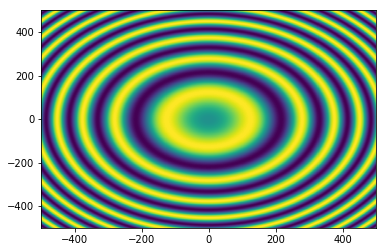

In [256]:
plt.pcolormesh(nd.x, nd.y, nd.num_f)

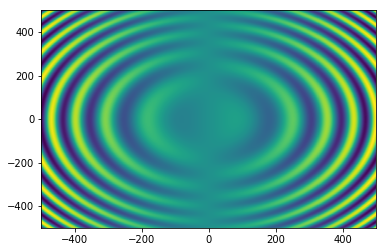

In [257]:
plt.pcolormesh(nd.x, nd.y, nd.num_dfdx)

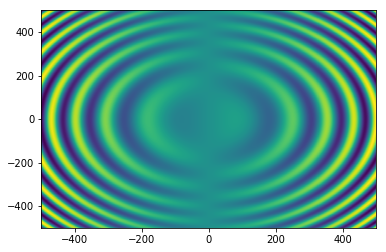

In [258]:
plt.pcolormesh(nd.x, nd.y, nd.get_conv(X.x,False))

C:\Users\safoe\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


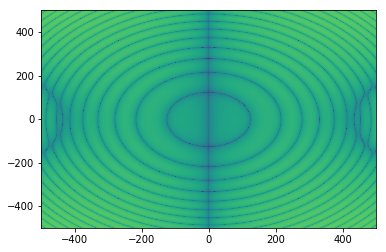

In [268]:
plt.pcolormesh(nd.x, nd.y, np.log(np.abs(nd.get_conv(X.x,False) - nd.num_dfdx)))

In [259]:
np.linalg.norm(nd.get_conv(X.x) - nd.num_dfdx)/nd.num**2

0.00023147161143504617

In [260]:
np.linalg.norm(nd.get_conv(X.x,False) - nd.num_dfdy)/nd.num**2

0.0002314716114350462

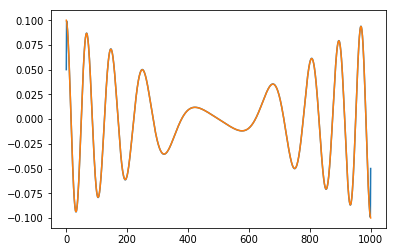

In [261]:
plt.plot(nd.get_conv(X.x,False)[30])
plt.plot(nd.num_dfdx[30])

In [ ]:
plt.plot(nd.get_conv(X.x,False)[30])
plt.plot()

### Картинки совпадают и по норме всё окей, но результат - дурацкий какой-то. Боюсь, что выбор функции как-то влияет. Если четко оставить только 2 ненулевых члена в mask, то будет +1/2 и -1/2, но если дать чуть больше свободы, то получается бред

In [262]:
X.x

array([-0.19901663,  0.89866545])

In [269]:
nd.arg_to_core_1(X.x)

array([[-0.19901663,  0.89866545, -0.19901663],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.19901663, -0.89866545,  0.19901663]])

### Дальше не читай

In [356]:
mask = np.array([
            [0,1,0],
            [1,0,1],
            [0,1,0]])
core = np.repeat(Y.x, 3)
core = core.reshape((3,3)) * mask
DFDX = sg.convolve2d(nd.num_f, core, mode='same', boundary='symm')

In [139]:
np.repeat(np.array([1,2,3]).reshape((1,3)),3,axis=0)

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

In [137]:
np.array([1,2,3]).reshape((3,1))

array([[1],
       [2],
       [3]])

In [355]:
mask = np.array([
            [0,1,0],
            [1,0,1],
            [0,1,0]])
core = np.repeat(Y.x, 3)
core = core.reshape((3,3)) * mask

In [280]:
core

array([[ 0.00000000e+00,  1.04235037e-01,  0.00000000e+00],
       [ 3.01484718e-07,  3.01484718e-07,  3.01484718e-07],
       [-0.00000000e+00, -1.04235345e-01, -0.00000000e+00]])

In [201]:
np.linspace(-1,1,21)

array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
        0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

In [238]:
print(nd.x[0])

[-1000.  -999.  -998. ...   998.   999.  1000.]


In [21]:
a = np.ones((3,1))
a.flatten().tolist()

[1.0, 1.0, 1.0]